In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## LR Finder - https://github.com/davidtvs/pytorch-lr-finder

In [ ]:
!pip install torch-lr-finder
!pip install torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [ ]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 13011107.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4,\
                       pin_memory=True) if cuda else\
                      dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


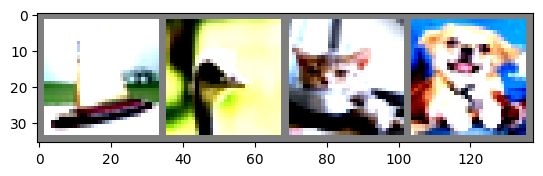

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
from custom_resnet import ResNet

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
    ResidualBlock-12          [-1, 128, 16, 16]               0
       LayerBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.07E-02


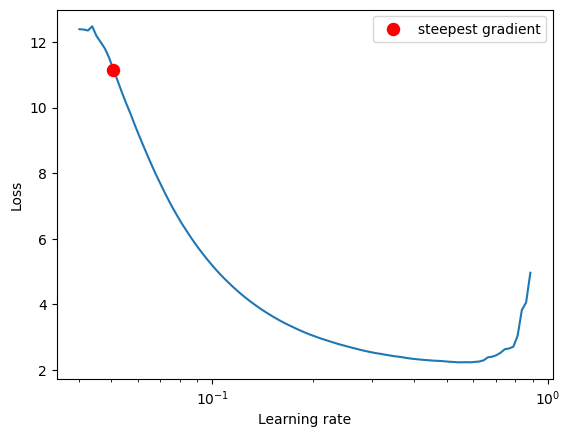

In [ ]:
from torch_lr_finder import LRFinder

model = ResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=5.07E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=1.1052912473678589 Batch_id=97 Accuracy=47.67: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0029, Accuracy: 5317/10000 (53.17%)

EPOCH: 1


Loss=0.8848427534103394 Batch_id=97 Accuracy=66.50: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]



Test set: Average loss: 0.0017, Accuracy: 7256/10000 (72.56%)

EPOCH: 2


Loss=0.7397617101669312 Batch_id=97 Accuracy=75.73: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]



Test set: Average loss: 0.0021, Accuracy: 6755/10000 (67.55%)

EPOCH: 3


Loss=0.47960948944091797 Batch_id=97 Accuracy=79.15: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.0022, Accuracy: 6624/10000 (66.24%)

EPOCH: 4


Loss=0.5815489292144775 Batch_id=97 Accuracy=81.03: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.0029, Accuracy: 6434/10000 (64.34%)

EPOCH: 5


Loss=0.5388842225074768 Batch_id=97 Accuracy=81.37: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 0.0026, Accuracy: 5987/10000 (59.87%)

EPOCH: 6


Loss=0.46406614780426025 Batch_id=97 Accuracy=82.24: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]



Test set: Average loss: 0.0017, Accuracy: 7249/10000 (72.49%)

EPOCH: 7


Loss=0.4148968756198883 Batch_id=97 Accuracy=83.44: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.0020, Accuracy: 7039/10000 (70.39%)

EPOCH: 8


Loss=0.4725606143474579 Batch_id=97 Accuracy=83.71: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0013, Accuracy: 7746/10000 (77.46%)

EPOCH: 9


Loss=0.35900363326072693 Batch_id=97 Accuracy=84.61: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.0017, Accuracy: 7315/10000 (73.15%)

EPOCH: 10


Loss=0.436538428068161 Batch_id=97 Accuracy=85.16: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]



Test set: Average loss: 0.0017, Accuracy: 7137/10000 (71.37%)

EPOCH: 11


Loss=0.46899667382240295 Batch_id=97 Accuracy=85.42: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.0013, Accuracy: 7819/10000 (78.19%)

EPOCH: 12


Loss=0.46642208099365234 Batch_id=97 Accuracy=86.19: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set: Average loss: 0.0016, Accuracy: 7435/10000 (74.35%)

EPOCH: 13


Loss=0.3889060318470001 Batch_id=97 Accuracy=86.53: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.0015, Accuracy: 7522/10000 (75.22%)

EPOCH: 14


Loss=0.3748331367969513 Batch_id=97 Accuracy=87.63: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.0012, Accuracy: 8100/10000 (81.00%)

EPOCH: 15


Loss=0.41439497470855713 Batch_id=97 Accuracy=88.28: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.0013, Accuracy: 7808/10000 (78.08%)

EPOCH: 16


Loss=0.388825923204422 Batch_id=97 Accuracy=89.07: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.0011, Accuracy: 8288/10000 (82.88%)

EPOCH: 17


Loss=0.3324723243713379 Batch_id=97 Accuracy=90.25: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.0011, Accuracy: 8143/10000 (81.43%)

EPOCH: 18


Loss=0.2527564764022827 Batch_id=97 Accuracy=91.77: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.0011, Accuracy: 8198/10000 (81.98%)

EPOCH: 19


Loss=0.2566816508769989 Batch_id=97 Accuracy=93.20: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 0.0010, Accuracy: 8375/10000 (83.75%)

EPOCH: 20


Loss=0.16464625298976898 Batch_id=97 Accuracy=95.32: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.0009, Accuracy: 8631/10000 (86.31%)

EPOCH: 21


Loss=0.09111455827951431 Batch_id=97 Accuracy=97.57: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set: Average loss: 0.0008, Accuracy: 8787/10000 (87.87%)

EPOCH: 22


Loss=0.01579940877854824 Batch_id=97 Accuracy=99.52: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]



Test set: Average loss: 0.0007, Accuracy: 8896/10000 (88.96%)

EPOCH: 23


Loss=0.00330061255954206 Batch_id=97 Accuracy=99.99: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.0008, Accuracy: 8956/10000 (89.56%)

